In [1]:
import pandas as pd
import datetime
from datetime import date
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import math
import cryptocompare

import sys
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 

from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
sns.set(style="darkgrid", color_codes=True)

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs

### Data

In [2]:
btc_1 = pd.DataFrame(cryptocompare.get_historical_price_day('BTC', currency='USD', toTs=pd.to_datetime('2017-03-21')))
btc_2 = pd.DataFrame(cryptocompare.get_historical_price_day('BTC', currency='USD', toTs=pd.to_datetime('2021-03-01')))
btc = pd.concat([btc_1, btc_2])
btc = btc.set_index('time')
btc.index = pd.to_datetime(btc.index, unit='s')
stock_prices = btc[btc.index >= pd.to_datetime('2015-01-01')][['close']]
stock_prices['retornos'] = np.log(stock_prices['close']).diff()
stock_prices = stock_prices.dropna()
stock_prices.columns = ['BTC-USD', 'retornos']
stock_prices

,BTC-USD,retornos
time,,
2015-01-02,315.21,0.001016
2015-01-03,287.13,-0.093304
2015-01-04,264.72,-0.081262
2015-01-05,274.84,0.037516
2015-01-06,282.27,0.026675
...,...,...
2021-02-25,47082.87,-0.054863
2021-02-26,46324.50,-0.016238
2021-02-27,46191.39,-0.002878


In [3]:
#from fitter import Fitter
#from fitter import get_distributions
#f = Fitter(stock_prices['retornos'])
#f.fit()
#f.summary()

In [4]:
##Histograma
#fig = plt.figure(figsize=[15,5])
#ax = plt.subplot(111)
#ax.hist(stock_prices['retornos'], bins=75, range=(-0.25,0.25), alpha=0.5)
#
##Normal Distribution
#ax_2 = ax.twinx()
#mu = np.mean(stock_prices['retornos'])
#sigma = np.std(stock_prices['retornos'])
#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#ax_2.plot(x, stats.norm.pdf(x, mu, sigma), color='red')
#plt.show()

In [5]:
#from scipy.stats import gennorm
##Histograma
#fig = plt.figure(figsize=[15,5])
#ax = plt.subplot(111)
#ax.hist(stock_prices['retornos'], bins=75, range=(-0.25,0.25), alpha=0.5)
#
##Distribucion Generalize Normal
#ax_2 = ax.twinx()
#param_gn = f.fitted_param['gennorm']
#X_gn = np.linspace(-0.25,0.25, 99999)
#pdf_fitted_gn = gennorm.pdf(X_gn, *param_gn)
#ax_2.plot(X_gn, pdf_fitted_gn,color='red')
#plt.show()

In [6]:
#Divido la data en train y test
#Train tomo los primeros 5 años, test el restante año
n_test = 366*5
train, test = stock_prices[:n_test], stock_prices[n_test:]

In [11]:
train.tail()

,BTC-USD,retornos
time,,
2020-01-01,7189.94,0.000843
2020-01-02,6965.72,-0.031682
2020-01-03,7339.70,0.052297
2020-01-04,7357.50,0.002422
2020-01-05,7359.96,0.000334


In [7]:
x = train['retornos'].dropna()
y = train['BTC-USD']

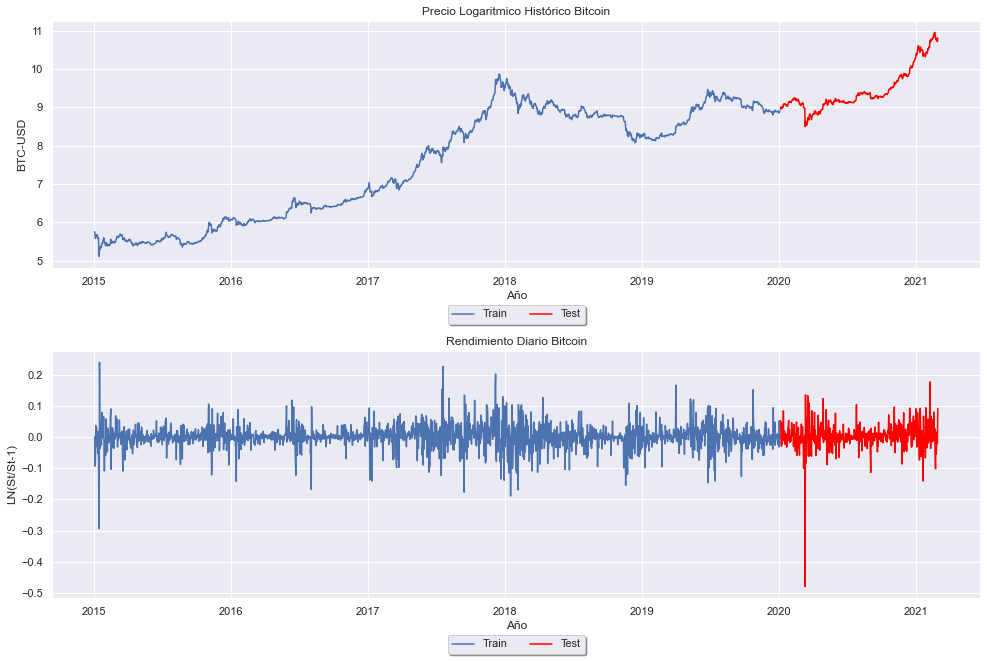

In [8]:
#Grafico el precio
fig, axs = plt.subplots(2, 1, figsize=(15,10))
#plt.style.use('seaborn-whitegrid')
fig.tight_layout(pad=5)
axs[0].set_title('Precio Logaritmico Histórico Bitcoin')
axs[0].set_xlabel('Año')
axs[0].set_ylabel('BTC-USD')
axs[0].plot(train.index, np.log(train['BTC-USD']), label='Train')
axs[0].plot(test.index, np.log(test['BTC-USD']), label='Test', color='red')
axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2)
#Retornos
axs[1].set_title('Rendimiento Diario Bitcoin')
axs[1].set_xlabel('Año')
axs[1].set_ylabel('LN(St/St-1)')
axs[1].plot(train.index, train.retornos, label='Train')
axs[1].plot(test.index, test.retornos, label='Test', color='red')
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2)

### Tests

In [11]:
#Test KPSS
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
kpss_test(x)

KPSS Statistic: 0.15356261617871161
p-value: 0.1
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\dguelman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [12]:
#Test ADF
import statsmodels
from statsmodels.tsa.stattools import adfuller
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(x, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -43.725943
P-Value                    0.000000
# Lags Used                0.000000
# Observations Used     1829.000000
Critical Value (1%)       -3.433930
Critical Value (5%)       -2.863122
Critical Value (10%)      -2.567612
dtype: float64
Is the time series stationary? True


In [13]:
#Test ARCH LM
#Hipotesis nula es que no hay efecto ARCH.
#El pvalor cuanto mas alto es, mas argumento tenes para no rechazar H0. 
#Cuanto menor es, es peor porque puede caer en zona de rechazo de H0
import statsmodels.api as sm
params_arch_lm = statsmodels.stats.diagnostic.het_arch(x)
arch_lm = pd.Series(params_arch_lm, index=['lm','lmpval','fval','fpval'])
print(arch_lm)
if arch_lm['lmpval'] < 0.05:
    print('Rechaza la hipotesis nula')
    print('Hay efecto ARCH')
else:
    print('No echaza la hipotesis nula')
    print('No Hay efecto ARCH')

lm        1.610559e+02
lmpval    7.502813e-22
fval      6.971489e+00
fpval     5.014400e-23
dtype: float64
Rechaza la hipotesis nula
Hay efecto ARCH


#### Modelo ARIMA

In [36]:
from statsmodels.tsa.arima_model import ARIMA
p_ls = [0,1]
q_ls = [0,1]
d_ls = [0,1]
aic_ls = []
bic_ls = []
for p in p_ls:
    for q in q_ls:
        for d in d_ls:
            print(f'######### ARIMA({p}, {q}, {d}) ##########')
            model = ARIMA(x, order=(p,q,d))
            model_fit = model.fit(disp=0)
            aic = model_fit.aic
            bic = model_fit.bic
            aic_ls.append(aic)
            bic_ls.append(bic)
            print(f'AIC: {aic}')
            print(f'BIC: {bic}')
print(np.min(aic_ls))
print(np.min(bic_ls))

######### ARIMA(0, 0, 0) ##########
AIC: -6631.526253235314
BIC: -6620.502110743642
######### ARIMA(0, 0, 1) ##########
AIC: -6630.484539466539
BIC: -6613.948325729032
######### ARIMA(0, 1, 0) ##########
AIC: -5318.0405652893305
BIC: -5307.017515992548
######### ARIMA(0, 1, 1) ##########
AIC: -6617.522711899563
BIC: -6600.98813795439
######### ARIMA(1, 0, 0) ##########
AIC: -6630.470843995368
BIC: -6613.9346302578615
######### ARIMA(1, 0, 1) ##########
AIC: -6628.502087438219
BIC: -6606.453802454877
######### ARIMA(1, 1, 0) ##########
AIC: -5861.013061261287
BIC: -5844.478487316114
######### ARIMA(1, 1, 1) ##########
AIC: -6616.627333912549
BIC: -6594.581235318986
-6631.526253235314
-6620.502110743642


### Modelar: Estimacion de parametros para GARCH y EGARCH

#### Fit GARCH models to cryptocurrency

Financial markets tend to react to positive and negative news shocks very differently, and one example is the dramatic swings observed in the cryptocurrency market in recent years.

We will implement a GJR-GARCH and an EGARCH model respectively in Python, which are popular choices to model the asymmetric responses of volatility.

In [14]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [15]:
#plot_correlogram(x, lags=100, title='BTCUSD (Log, Diff)')

In [16]:
#plot_correlogram(x.sub(x.mean()).pow(2), lags=100, title='BTCUSD Daily Volatility')

#### GARCH (1,1)
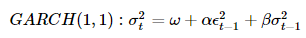

In [65]:
# Fit a GARCH(1, 1)
basic_gm = arch_model(x, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 't')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)
#Parametros
gm_mu = gm_result.params.mu
gm_omega = gm_result.params.omega
gm_alpha = gm_result.params['alpha[1]']
gm_beta = gm_result.params['beta[1]']
#Ultima volatilidad y retorno
gm_vol_t = gm_result.conditional_volatility[-1:].values[0]
gm_ret_t = x[-1:].values[0]
#Ultimo Error
gm_error_t = gm_ret_t - gm_mu
# Display model fitting summary
print(gm_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3755.2284777971945
            Iterations: 3
            Function evaluations: 48
            Gradient evaluations: 3
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                     retornos   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                3755.23
Distribution:      Standardized Student's t   AIC:                          -7500.46
Method:                  Maximum Likelihood   BIC:                          -7472.90
                                              No. Observations:                 1830
Date:                      Thu, Jun 03 2021   Df Residuals:                     1829
Time:                              16:15:20   Df Model:                            1
                          

In [66]:
gm_result.params

mu          0.001882
omega       0.000031
alpha[1]    0.100000
beta[1]     0.880000
nu          4.846844
Name: params, dtype: float64

In [67]:
#Volatilidad estimada
gm_forecast = gm_result.forecast(horizon = 1)
gm_volatilidad = gm_forecast.variance[-1:].values[0][0]**0.5
gm_volatilidad

0.027666905680131238

In [68]:
#Pruebo la formula contra el forecast
gm_forecast = gm_result.forecast(horizon = 1)
print(gm_forecast.variance[-1:].values[0][0])
gm_variance_t1 = gm_omega + gm_alpha*(gm_error_t)**2 + gm_beta*(gm_vol_t)**2
print(gm_variance_t1)

0.0007654576699132782
0.0007654576699132783


In [9]:
print(train.iloc[-1,0])

7359.96


In [69]:
#Simulacion Montecharles
def gm_simular(dias, num_sim):
    df = pd.DataFrame()
    fig = plt.figure(figsize=[15,5])
    for ns in range(0,num_sim):
        gm_variance_t1 = gm_omega + gm_alpha*(gm_error_t)**2 + gm_beta*(gm_vol_t)**2
        precio_t1 = train.iloc[-1,0]
        simulacion = []
        for i in range(1,dias+1):
            gm_ret_t1 = (gm_variance_t1**0.5) *  np.random.normal() #+ gm_mu
            gm_error_t1 = gm_ret_t1 #- gm_mu
            gm_variance_t1 = gm_omega + gm_alpha*(gm_error_t1)**2 + gm_beta*(gm_variance_t1)
            precio_t1 = precio_t1 * np.exp(-0.5*gm_variance_t1 + gm_ret_t1)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
        plt.plot(df.index, df['{0}'.format(ns)], alpha = 1)
        plt.title('GARCH')
        plt.
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - train.iloc[-1,0]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)

    #VaR y TVaR a 1 dia
    df_dia10 = df_1.iloc[:,-1].sort_values(ascending=False).reset_index()
    df_dia10['Perdida'] = df_dia10.iloc[:,1] - train.iloc[-1,0]
    df_dia10['Prob'] = 1/len(df_dia10)
    df_dia10.drop(columns='index', inplace=True)
    df_dia10['Prob_Acum'] = (df_dia10.index+1)/len(df_dia10)
    
    for c in [0.99, 0.95, 0.9]:
        var_1d = df_dia1[df_dia1['Prob_Acum'] == c]['Perdida']
        tvar_1d = np.mean(df_dia1[df_dia1['Prob_Acum'] > c]['Perdida'])
        var_10d = df_dia10[df_dia10['Prob_Acum'] == c]['Perdida']
        tvar_10d = np.mean(df_dia10[df_dia10['Prob_Acum'] > c]['Perdida'])
        print(f'--------{int(c*100)}%----------')
        print(f'VaR 1 Dia {int(c*100)}%: {var_1d.values[0]}')
        print(f'TVaR 1 Dia {int(c*100)}%: {tvar_1d}')
        print(f'VaR 10 Dia {int(c*100)}%: {var_10d.values[0]}')
        print(f'TVaR 10 Dia {int(c*100)}%: {tvar_10d}')
    return(plt)

#### GJR-GARCH
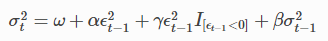

In [70]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(x, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')
#Parametros
gjrgm_mu = gjrgm_result.params.mu
gjrgm_omega = gjrgm_result.params.omega
gjrgm_alpha = gjrgm_result.params['alpha[1]']
gjrgm_gamma = gjrgm_result.params['gamma[1]']
gjrgm_beta = gjrgm_result.params['beta[1]']
#Ultima volatilidad y retorno
gjrgm_vol_t = gjrgm_result.conditional_volatility[-1:].values[0]
gjrgm_ret_t = x[-1:].values[0]
#Ultimo Error
gjrgm_error_t = gjrgm_ret_t - gjrgm_mu
#It-1
if gjrgm_error_t<0:
    gjrgm_I = 1
else:
    gjrgm_I = 0
# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     retornos   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                3757.03
Distribution:      Standardized Student's t   AIC:                          -7502.06
Method:                  Maximum Likelihood   BIC:                          -7468.99
                                              No. Observations:                 1830
Date:                      Thu, Jun 03 2021   Df Residuals:                     1829
Time:                              16:15:26   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [71]:
gjrgm_result.params

mu          0.001842
omega       0.000031
alpha[1]    0.100000
gamma[1]    0.010000
beta[1]     0.874996
nu          4.833080
Name: params, dtype: float64

In [72]:
#Volatilidad estimada
gjrgm_forecast = gjrgm_result.forecast(horizon = 1)
gjrgm_volatilidad = gjrgm_forecast.variance[-1:].values[0][0]**0.5
gjrgm_volatilidad

0.027336338009170125

In [73]:
#Pruebo la formula
gjrgm_forecast = gjrgm_result.forecast(horizon = 1)
print(gjrgm_forecast.variance[-1:].values[0][0])
gjrgm_variance_t1 = gjrgm_omega + (gjrgm_alpha + gjrgm_gamma*gjrgm_I)*(gjrgm_error_t)**2 + gjrgm_beta*(gjrgm_vol_t)**2
print(gjrgm_variance_t1)

0.0007472753757515993
0.0007472753757515993


In [93]:
#Simulacion Montecharles
def gjrgm_simular(dias, num_sim):
    df = pd.DataFrame()
    fig = plt.figure(figsize=[15,5])
    for ns in range(0,num_sim):
        gjrgm_variance_t1 = gjrgm_omega + (gjrgm_alpha + gjrgm_gamma*gjrgm_I)*(gjrgm_error_t)**2 + gjrgm_beta*(gjrgm_vol_t)**2
        if gjrgm_error_t<0:
            gjrgm_I_t1 = 1
        else:
            gjrgm_I_t1 = 0
        precio_t1 = train.iloc[-1,0]
        simulacion = []
        for i in range(1,dias+1):
            gjrgm_ret_t1 = (gjrgm_variance_t1**0.5) *  np.random.normal() #+ gjrgm_mu
            gjrgm_error_t1 = gjrgm_ret_t1 #- gjrgm_mu
            if gjrgm_error_t1<0:
                gjrgm_I_t1 = 1
            else:
                gjrgm_I_t1 = 0
            gjrgm_variance_t1 = gjrgm_omega + (gjrgm_alpha + gjrgm_gamma*gjrgm_I_t1)*(gjrgm_error_t1)**2 +\
                                gjrgm_beta*(gjrgm_variance_t1)
            precio_t1 = precio_t1 * np.exp(-0.5*gjrgm_variance_t1 + gjrgm_ret_t1)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
        plt.plot(df.index, df['{0}'.format(ns)], alpha = 1)
        plt.title('GJR-GARCH')
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - train.iloc[-1,0]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)

    #VaR y TVaR a 1 dia
    df_dia10 = df_1.iloc[:,-1].sort_values(ascending=False).reset_index()
    df_dia10['Perdida'] = df_dia10.iloc[:,1] - train.iloc[-1,0]
    df_dia10['Prob'] = 1/len(df_dia10)
    df_dia10.drop(columns='index', inplace=True)
    df_dia10['Prob_Acum'] = (df_dia10.index+1)/len(df_dia10)
    
    for c in [0.99, 0.95, 0.9]:
        var_1d = df_dia1[df_dia1['Prob_Acum'] == c]['Perdida']
        tvar_1d = np.mean(df_dia1[df_dia1['Prob_Acum'] > c]['Perdida'])
        var_10d = df_dia10[df_dia10['Prob_Acum'] == c]['Perdida']
        tvar_10d = np.mean(df_dia10[df_dia10['Prob_Acum'] > c]['Perdida'])
        print(f'--------{int(c*100)}%----------')
        print(f'VaR 1 Dia {int(c*100)}%: {var_1d.values[0]}')
        print(f'TVaR 1 Dia {int(c*100)}%: {tvar_1d}')
        print(f'VaR 10 Dia {int(c*100)}%: {var_10d.values[0]}')
        print(f'TVaR 10 Dia {int(c*100)}%: {tvar_10d}')
    return(plt)

#### EGARCH
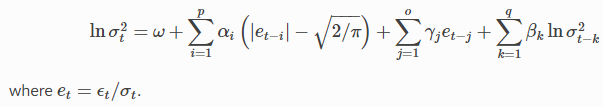

In [75]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(x, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')
#Parametros
egarch_mu = egarch_result.params.mu
egarch_omega = egarch_result.params.omega
egarch_alpha = egarch_result.params['alpha[1]']
egarch_gamma = egarch_result.params['gamma[1]']
egarch_beta = egarch_result.params['beta[1]']
#Ultima volatilidad y retorno
egarch_vol_t = egarch_result.conditional_volatility[-1:].values[0]
egarch_ret_t = x[-1:].values[0]
#Ultimo Error
egarch_error_t = egarch_ret_t - egarch_mu

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                     retornos   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                3818.92
Distribution:      Standardized Student's t   AIC:                          -7625.83
Method:                  Maximum Likelihood   BIC:                          -7592.76
                                              No. Observations:                 1830
Date:                      Thu, Jun 03 2021   Df Residuals:                     1829
Time:                              16:15:28   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [76]:
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                     retornos   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                3818.92
Distribution:      Standardized Student's t   AIC:                          -7625.83
Method:                  Maximum Likelihood   BIC:                          -7592.76
                                              No. Observations:                 1830
Date:                      Thu, Jun 03 2021   Df Residuals:                     1829
Time:                              16:15:28   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [77]:
egarch_result.params

mu          0.001652
omega       0.026402
alpha[1]    0.325845
gamma[1]    0.050572
beta[1]     0.990446
nu          2.501993
Name: params, dtype: float64

In [78]:
#Volatilidad estimada
egarch_forecast = egarch_result.forecast(horizon = 1)
egarch_volatilidad = egarch_forecast.variance[-1:].values[0][0]**0.5
egarch_volatilidad

0.03434789291345995

In [79]:
#Pruebo la formula
egarch_forecast = egarch_result.forecast(horizon = 1)
print(egarch_forecast.variance[-1:].values[0][0])
egarch_variance_t1 = np.exp(egarch_omega + egarch_alpha*(np.absolute(egarch_error_t/egarch_vol_t) - (2/np.pi)**0.5) +\
       egarch_gamma*egarch_error_t/egarch_vol_t + egarch_beta*np.log(egarch_vol_t**2))
print(egarch_variance_t1)

0.0011797777475945125
0.0011797777475945125


In [94]:
#Simulacion Montecharles
def egarch_simular(dias, num_sim):
    df = pd.DataFrame()
    fig = plt.figure(figsize=[15,5])
    for ns in range(0,num_sim):
        egarch_variance_t1 = np.exp(egarch_omega + egarch_alpha*(np.absolute(egarch_error_t/egarch_vol_t) - (2/np.pi)**0.5) +\
                                   egarch_gamma*egarch_error_t/egarch_vol_t + egarch_beta*np.log(egarch_vol_t**2))
        precio_t1 = train.iloc[-1,0]
        simulacion = []
        for i in range(1,dias+1):
            egarch_ret_t1 = (egarch_variance_t1**0.5) *  np.random.normal() #+ egarch_mu
            egarch_error_t1 = egarch_ret_t1 #- egarch_mu
            egarch_variance_t1 = np.exp(egarch_omega + egarch_alpha*\
                                        (np.absolute(egarch_error_t/egarch_variance_t1**0.5) - (2/np.pi)**0.5) +\
                                        egarch_gamma*egarch_error_t/egarch_variance_t1**0.5 +\
                                        egarch_beta*np.log(egarch_variance_t1))
            precio_t1 = precio_t1 * np.exp(-0.5*egarch_variance_t1 + egarch_ret_t1)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
        plt.plot(df.index, df['{0}'.format(ns)], alpha = 1)
        plt.title('EGARCH')
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - train.iloc[-1,0]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)

    #VaR y TVaR a 1 dia
    df_dia10 = df_1.iloc[:,-1].sort_values(ascending=False).reset_index()
    df_dia10['Perdida'] = df_dia10.iloc[:,1] - train.iloc[-1,0]
    df_dia10['Prob'] = 1/len(df_dia10)
    df_dia10.drop(columns='index', inplace=True)
    df_dia10['Prob_Acum'] = (df_dia10.index+1)/len(df_dia10)
    
    for c in [0.99, 0.95, 0.9]:
        var_1d = df_dia1[df_dia1['Prob_Acum'] == c]['Perdida']
        tvar_1d = np.mean(df_dia1[df_dia1['Prob_Acum'] > c]['Perdida'])
        var_10d = df_dia10[df_dia10['Prob_Acum'] == c]['Perdida']
        tvar_10d = np.mean(df_dia10[df_dia10['Prob_Acum'] > c]['Perdida'])
        print(f'--------{int(c*100)}%----------')
        print(f'VaR 1 Dia {int(c*100)}%: {var_1d.values[0]}')
        print(f'TVaR 1 Dia {int(c*100)}%: {tvar_1d}')
        print(f'VaR 10 Dia {int(c*100)}%: {var_10d.values[0]}')
        print(f'TVaR 10 Dia {int(c*100)}%: {tvar_10d}')
    return(plt)

#### EWMA
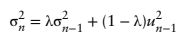

In [81]:
def ewma(df):
    # Volatilidad EWMA
    lamda = 0.94                          ############### Supuesto lambda = 0.94 ###############
    weight = (1-lamda)*(lamda**df.reset_index().index)
    ew = ((df.retornos)**2) * weight
    # Diaria
    vol_ewma_d = np.sqrt(ew.sum()/(1-lamda**len(df)))
    return(vol_ewma_d)

x_ewma = pd.DataFrame(x.copy()).sort_values('time', ascending=False)
volat_ew = []
for i in x_ewma.reset_index().index:
    vol_ew = ewma(x_ewma.iloc[i:])
    volat_ew.append(vol_ew)
x_ewma['EWMA'] = volat_ew

In [82]:
#Volatilidad estimada
ewma_volatilidad = x_ewma['EWMA'][0]
ewma_volatilidad

0.026434404909855772

In [95]:
#Simulacion Montecharles
def ewma_simular(dias, num_sim):
    df = pd.DataFrame()
    fig = plt.figure(figsize=[15,5])
    for ns in range(0,num_sim):
        ewma_ret_df = pd.DataFrame(pd.DataFrame(x).sort_values('time', ascending=False).reset_index().retornos)
        precio_t1 = train.iloc[-1,0]
        ewma_vol_t1 = x_ewma['EWMA'][0]
        simulacion = []
        for i in range(1,dias+1):
            ewma_ret_t1 = ewma_vol_t1 *  np.random.normal()
            precio_t1 = precio_t1 * np.exp(-0.5*(ewma_vol_t1**2) + ewma_ret_t1)
            
            df_ret_t1 = pd.DataFrame(list({ewma_ret_t1}), columns=['retornos'])
            ewma_ret_df = pd.concat([df_ret_t1, ewma_ret_df])
            ewma_vol_t1 = ewma(ewma_ret_df)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
        plt.plot(df.index, df['{0}'.format(ns)], alpha = 1)
        plt.title('EWMA')
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - train.iloc[-1,0]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)

    #VaR y TVaR a 1 dia
    df_dia10 = df_1.iloc[:,-1].sort_values(ascending=False).reset_index()
    df_dia10['Perdida'] = df_dia10.iloc[:,1] - train.iloc[-1,0]
    df_dia10['Prob'] = 1/len(df_dia10)
    df_dia10.drop(columns='index', inplace=True)
    df_dia10['Prob_Acum'] = (df_dia10.index+1)/len(df_dia10)
    
    for c in [0.99, 0.95, 0.9]:
        var_1d = df_dia1[df_dia1['Prob_Acum'] == c]['Perdida']
        tvar_1d = np.mean(df_dia1[df_dia1['Prob_Acum'] > c]['Perdida'])
        var_10d = df_dia10[df_dia10['Prob_Acum'] == c]['Perdida']
        tvar_10d = np.mean(df_dia10[df_dia10['Prob_Acum'] > c]['Perdida'])
        print(f'--------{int(c*100)}%----------')
        print(f'VaR 1 Dia {int(c*100)}%: {var_1d.values[0]}')
        print(f'TVaR 1 Dia {int(c*100)}%: {tvar_1d}')
        print(f'VaR 10 Dia {int(c*100)}%: {var_10d.values[0]}')
        print(f'TVaR 10 Dia {int(c*100)}%: {tvar_10d}')
    return(plt)

#### Comparacion Grafica Volatilidades

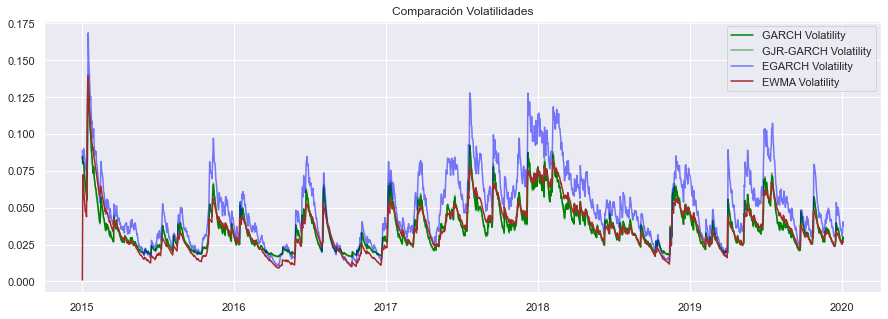

In [96]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility
gm_vol = gm_result.conditional_volatility
ewma_vol = x_ewma['EWMA']
# Plot the actual Bitcoin returns
plt.subplots(figsize=(15, 5))
plt.title('Comparación Volatilidades')
#plt.plot(x, color = 'grey', alpha = 0.4, label = 'Price Returns')
# Plot GARCH estimated volatility
plt.plot(gm_vol, color = 'green', label = 'GARCH Volatility', alpha=1)
# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'green', label = 'GJR-GARCH Volatility', alpha=0.5)
# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'blue', label = 'EGARCH Volatility', alpha=0.5)
# Plot EWMA  estimated volatility
plt.plot(ewma_vol, color = 'brown', label = 'EWMA Volatility', alpha=1)
plt.legend(loc = 'upper right')
plt.show()

In [97]:
vols = pd.DataFrame(columns=['GARCH', 'GJR-GARCH', 'EGARCH', 'EWMA', 'HISTORICA'])
vols['GARCH'] = gm_result.conditional_volatility
vols['GJR-GARCH'] = gjrgm_result.conditional_volatility
vols['EGARCH'] = egarch_result.conditional_volatility
vols['EWMA'] = x_ewma.sort_values('time', ascending=True)['EWMA']
vols['HISTORICA'] = x.sub(x.mean())
vols.head()

,GARCH,GJR-GARCH,EGARCH,EWMA,HISTORICA
time,,,,,
2015-01-02,0.084652,0.084652,0.088517,0.001016,-0.000706
2015-01-03,0.079607,0.079382,0.080685,0.066992,-0.095026
2015-01-04,0.080710,0.080875,0.086469,0.072369,-0.082985
2015-01-05,0.080342,0.080709,0.089870,0.064724,0.035794
2015-01-06,0.076410,0.076539,0.088208,0.058353,0.024953


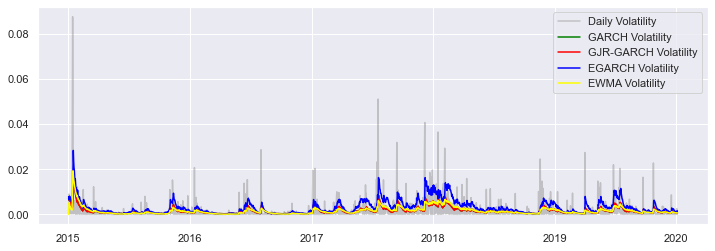

In [86]:
# Plot the actual Bitcoin volatility
plt.figure(figsize=(12,4))
plt.plot(x.sub(x.mean()).pow(2), color = 'grey', alpha = 0.4, label = 'Daily Volatility')
# Plot GARCH estimated volatility
plt.plot(gm_vol**2, color = 'green', label = 'GARCH Volatility')
# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol**2, color = 'red', label = 'GJR-GARCH Volatility')
# Plot EGARCH estimated volatility
plt.plot(egarch_vol**2, color = 'blue', label = 'EGARCH Volatility')
# Plot EWMA estimated volatility
plt.plot(ewma_vol**2, color = 'yellow', label = 'EWMA Volatility')
plt.legend(loc = 'upper right')
plt.show()

In [98]:
# Print each models BIC
print(f'GARCH BIC: {gm_result.bic}')
print(f'\nGJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GARCH BIC: -7472.896599365212

GJR-GARCH BIC: -7468.987351701422

EGARCH BIC: -7592.761465677675


In [99]:
# Print each models AIC
print(f'GARCH AIC: {gm_result.aic}')
print(f'\nGJR-GARCH AIC: {gjrgm_result.aic}')
print(f'\nEGARCH AIC: {egarch_result.aic}')

GARCH AIC: -7500.456955594389

GJR-GARCH AIC: -7502.059779176435

EGARCH AIC: -7625.833893152688


### Goodness of fit
Can model do a good job explaining the data?

1-Maximum likelihood

2-Information criteria (AIC, BIC)

***Maximum likelihood***: Maximize the probability of getting the data observed under the assumed model. Preferred models have larger likelihood values.

***Maximum likelihood estimation***: In statistics, maximum likelihood estimation (MLE) is a method of estimating the parameters of a probability distribution by maximizing a likelihood function, so that under the assumed statistical model the observed data is most probable. The point in the parameter space that maximizes the likelihood function is called the maximum likelihood estimate.

***Likelihood function***: In statistics, the likelihood function (often simply called the likelihood) measures the goodness of fit of a statistical model to a sample of data for given values of the unknown parameters. It is formed from the joint probability distribution of the sample, but viewed and used as a function of the parameters only, thus treating the random variables as fixed at the observed values. The likelihood function describes a hypersurface whose peak, if it exists, represents the combination of model parameter values that maximize the probability of drawing the sample obtained.

In [89]:
# Print the log-likelihodd of GARCH
print('Log-likelihood of GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of GJR GARCH
print('Log-likelihood of GJR GARCH :', gjrgm_result.loglikelihood)
# Print the log-likelihodd of EGARCH
print('Log-likelihood of skewt EGARCH :', egarch_result.loglikelihood)

Log-likelihood of GARCH : 3755.2284777971945
Log-likelihood of GJR GARCH : 3757.0298895882174
Log-likelihood of skewt EGARCH : 3818.916946576344


### Backtesting with MAE, MSE

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,6)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {float(round(mse,6))}')
    return mae, mse

# Backtest model with MAE, MSE
print('---EGARCH---')
evaluate(x.sub(x.mean()).pow(2), egarch_vol**2)
print('---GJR-GARCH---')
evaluate(x.sub(x.mean()).pow(2), gjrgm_vol**2)
print('---GARCH---')
evaluate(x.sub(x.mean()).pow(2), gm_vol**2)

---EGARCH---
Mean Absolute Error (MAE): 0.00282
Mean Squared Error (MSE): 2.4e-05
---GJR-GARCH---
Mean Absolute Error (MAE): 0.001854
Mean Squared Error (MSE): 1.8e-05
---GARCH---
Mean Absolute Error (MAE): 0.001854
Mean Squared Error (MSE): 1.8e-05


(0.0018543225557354913, 1.831344311505371e-05)

#### VaR y ES por formula

###### Retornos logaritmicos sigue un comportamiento normal
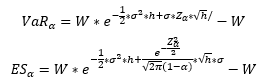

In [100]:
from scipy.stats import norm
w = train['BTC-USD'][-1]
modelos = {'GARCH':gm_volatilidad, 'GJR-GARCH':gjrgm_volatilidad, 'EGARCH':egarch_volatilidad, 'EWMA':ewma_volatilidad}
confianza = [0.99, 0.95, 0.9]
for i in modelos:
    print(f'------------------------------------------{i}------------------------------------------')
    for c in confianza:
        var_1d = w * np.exp(-0.5*(modelos[i])**2 + modelos[i] * norm.ppf(c)) - w
        var_10d = w * np.exp(-0.5*10*(modelos[i])**2 + modelos[i] * norm.ppf(c) * ((10) ** 0.5)) - w
        
        es_1d = w * np.exp(-0.5*(modelos[i])**2 + modelos[i] * ((np.exp(-(norm.ppf(c)**2)/2)) / (((2*np.pi) ** 0.5) * (1-c)))) - w
        es_10d = w * np.exp(-0.5*10*(modelos[i])**2 + ((10) ** 0.5) * modelos[i] * ((np.exp(-(norm.ppf(c)**2)/2)) / (((2*np.pi) ** 0.5) * (1-c)))) - w 
        print('----------VaR------------')
        print(f'VaR 1 dia {int(c*100)}%: {var_1d}')
        print(f'VaR 10 dia {int(c*100)}%: {var_10d}')
        print('----------ES------------')
        print(f'ES 1 dia {int(c*100)}%: {es_1d}')
        print(f'ES 10 dia {int(c*100)}%: {es_10d}')

------------------------------------------GARCH------------------------------------------
----------VaR------------
VaR 1 dia 99%: 486.28141361094004
VaR 10 dia 99%: 1626.872077635514
----------ES------------
ES 1 dia 99%: 560.188847770145
ES 10 dia 99%: 1897.298703128411
----------VaR------------
VaR 1 dia 95%: 339.7277744357707
VaR 10 dia 95%: 1106.700639314121
----------ES------------
ES 1 dia 95%: 429.259402560504
ES 10 dia 95%: 1421.9581868538708
----------VaR------------
VaR 1 dia 90%: 262.7224506567063
VaR 10 dia 90%: 841.8160072855635
----------ES------------
ES 1 dia 90%: 363.2240991085537
ES 10 dia 90%: 1188.6736953026602
------------------------------------------GJR-GARCH------------------------------------------
----------VaR------------
VaR 1 dia 99%: 480.32112944679375
VaR 10 dia 99%: 1605.8591485844527
----------ES------------
ES 1 dia 99%: 553.285943206778
ES 10 dia 99%: 1872.3824868144939
----------VaR------------
VaR 1 dia 95%: 335.6122806280573
VaR 10 dia 95%: 1092.9

#### VaR y ES por Simulacion

In [101]:
def simulation_full(dias, num_sim):
    print('------------------------------------------GARCH------------------------------------------')
    gm_simular(dias, num_sim)
    print('------------------------------------------GHR-GARCH------------------------------------------')
    gjrgm_simular(dias, num_sim)
    print('------------------------------------------EGARCH------------------------------------------')
    egarch_simular(dias, num_sim)
    print('------------------------------------------EWMA------------------------------------------')
    ewma_simular(dias, num_sim)

------------------------------------------GARCH------------------------------------------
--------99%----------
VaR 1 Dia 99%: -460.0858834093997
TVaR 1 Dia 99%: -526.9982602459056
VaR 10 Dia 99%: -1495.449204112384
TVaR 10 Dia 99%: -1756.2136569458821
--------95%----------
VaR 1 Dia 95%: -330.0774928748624
TVaR 1 Dia 95%: -410.4793986676008
VaR 10 Dia 95%: -1040.8689468993898
TVaR 10 Dia 95%: -1322.9483933331187
--------90%----------
VaR 1 Dia 90%: -258.1166890298264
TVaR 1 Dia 90%: -350.6639442815541
VaR 10 Dia 90%: -812.6772767837147
TVaR 10 Dia 90%: -1119.5686416251042
------------------------------------------GHR-GARCH------------------------------------------
--------99%----------
VaR 1 Dia 99%: -454.254269534541
TVaR 1 Dia 99%: -519.6046089329831
VaR 10 Dia 99%: -1502.6135994095584
TVaR 10 Dia 99%: -1757.9205893971032
--------95%----------
VaR 1 Dia 95%: -325.6106789276946
TVaR 1 Dia 95%: -405.82101664238127
VaR 10 Dia 95%: -1034.9179300546157
TVaR 10 Dia 95%: -1320.945590576836

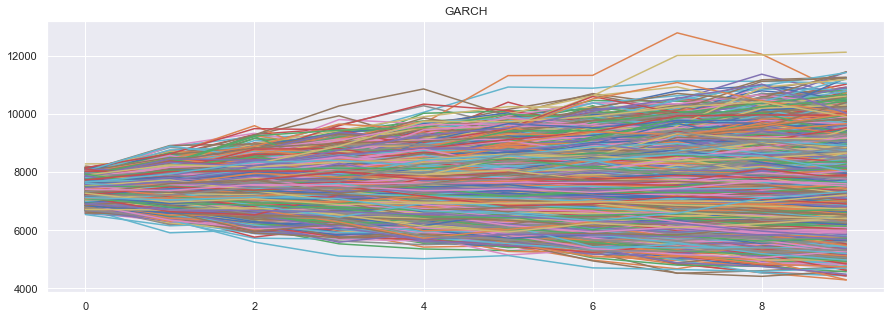

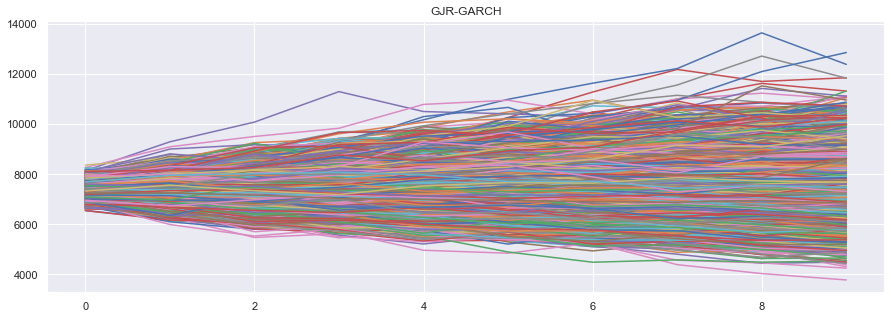

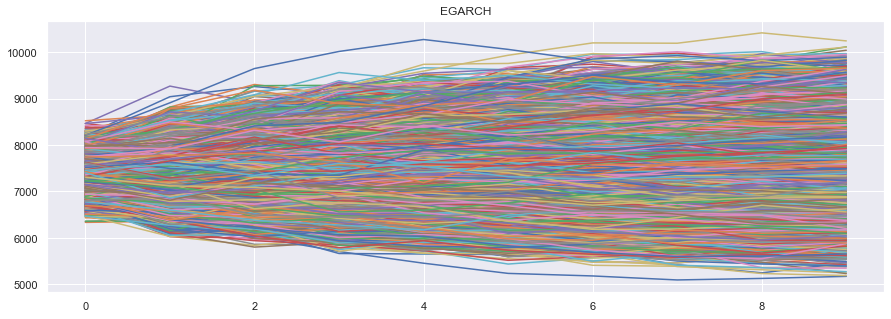

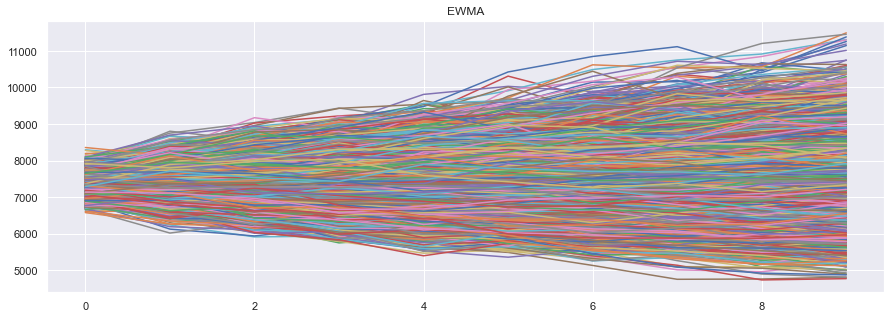

In [102]:
simulation_full(10,100000)

### Backtesting

In [103]:
#Simulacion Montecharles
def gm_simular_bt(ls, dias, num_sim):
    df = pd.DataFrame()
    for ns in range(0,num_sim):
        gm_variance_t1 = gm_omega + gm_alpha*(gm_error_t)**2 + gm_beta*(gm_vol_t)**2
        precio_t1 = ls[-1]
        simulacion = []
        for i in range(1,dias+1):
            gm_ret_t1 = (gm_variance_t1**0.5) *  np.random.normal() #+ gm_mu
            gm_error_t1 = gm_ret_t1 #- gm_mu
            gm_variance_t1 = gm_omega + gm_alpha*(gm_error_t1)**2 + gm_beta*(gm_variance_t1)
            precio_t1 = precio_t1 * np.exp(-0.5*gm_variance_t1 + gm_ret_t1)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - ls[-1]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)
    var_1d = df_dia1[df_dia1['Prob_Acum'] == 0.99]['Perdida']
    return(var_1d)

#Simulacion Montecharles
def gjrgm_simular_bt(ls, dias, num_sim):
    df = pd.DataFrame()
    for ns in range(0,num_sim):
        gjrgm_variance_t1 = gjrgm_omega + (gjrgm_alpha + gjrgm_gamma*gjrgm_I)*(gjrgm_error_t)**2 + gjrgm_beta*(gjrgm_vol_t)**2
        if gjrgm_error_t<0:
            gjrgm_I_t1 = 1
        else:
            gjrgm_I_t1 = 0
        precio_t1 = ls[-1]
        simulacion = []
        for i in range(1,dias+1):
            gjrgm_ret_t1 = (gjrgm_variance_t1**0.5) *  np.random.normal() #+ gjrgm_mu
            gjrgm_error_t1 = gjrgm_ret_t1 #- gjrgm_mu
            if gjrgm_error_t1<0:
                gjrgm_I_t1 = 1
            else:
                gjrgm_I_t1 = 0
            gjrgm_variance_t1 = gjrgm_omega + (gjrgm_alpha + gjrgm_gamma*gjrgm_I_t1)*(gjrgm_error_t1)**2 +\
                                gjrgm_beta*(gjrgm_variance_t1)
            precio_t1 = precio_t1 * np.exp(-0.5*gjrgm_variance_t1 + gjrgm_ret_t1)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - ls[-1]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)
    var_1d = df_dia1[df_dia1['Prob_Acum'] == 0.99]['Perdida']
    return(var_1d)

#Simulacion Montecharles
def egarch_simular_bt(ls, dias, num_sim):
    df = pd.DataFrame()
    for ns in range(0,num_sim):
        egarch_variance_t1 = np.exp(egarch_omega + egarch_alpha*(np.absolute(egarch_error_t/egarch_vol_t) - (2/np.pi)**0.5) +\
                                   egarch_gamma*egarch_error_t/egarch_vol_t + egarch_beta*np.log(egarch_vol_t**2))
        precio_t1 = ls[-1]
        simulacion = []
        for i in range(1,dias+1):
            egarch_ret_t1 = (egarch_variance_t1**0.5) *  np.random.normal() #+ egarch_mu
            egarch_error_t1 = egarch_ret_t1 #- egarch_mu
            egarch_variance_t1 = np.exp(egarch_omega + egarch_alpha*\
                                        (np.absolute(egarch_error_t/egarch_variance_t1**0.5) - (2/np.pi)**0.5) +\
                                        egarch_gamma*egarch_error_t/egarch_variance_t1**0.5 +\
                                        egarch_beta*np.log(egarch_variance_t1))
            precio_t1 = precio_t1 * np.exp(-0.5*egarch_variance_t1 + egarch_ret_t1)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - ls[-1]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)
    var_1d = df_dia1[df_dia1['Prob_Acum'] == 0.99]['Perdida']
    return(var_1d)

#Simulacion Montecharles
def ewma_simular_bt(ls, dias, num_sim):
    df = pd.DataFrame()
    for ns in range(0,num_sim):
        ewma_ret_df = pd.DataFrame(pd.DataFrame(x).sort_values('time', ascending=False).reset_index().retornos)
        precio_t1 = ls[-1]
        ewma_vol_t1 = x_ewma['EWMA'][0]
        simulacion = []
        for i in range(1,dias+1):
            ewma_ret_t1 = ewma_vol_t1 *  np.random.normal()
            precio_t1 = precio_t1 * np.exp(-0.5*(ewma_vol_t1**2) + ewma_ret_t1)
            
            df_ret_t1 = pd.DataFrame(list({ewma_ret_t1}), columns=['retornos'])
            ewma_ret_df = pd.concat([df_ret_t1, ewma_ret_df])
            ewma_vol_t1 = ewma(ewma_ret_df)
            simulacion.append(precio_t1)
        df['{0}'.format(ns)] = simulacion
    df_1 = df.transpose()
    #VaR y TVaR a 1 dia
    df_dia1 = df_1.iloc[:,0].sort_values(ascending=False).reset_index()
    df_dia1['Perdida'] = df_dia1.iloc[:,1] - ls[-1]
    df_dia1['Prob'] = 1/len(df_dia1)
    df_dia1.drop(columns='index', inplace=True)
    df_dia1['Prob_Acum'] = (df_dia1.index+1)/len(df_dia1)
    var_1d = df_dia1[df_dia1['Prob_Acum'] == 0.99]['Perdida']
    return(var_1d)

In [104]:
#BackTesting GARCH
def gm_backtesting(dias, num_sim):
    df_train = train.iloc[:,0]
    indicador_gm = []
    for i in range(0, len(test)):
        var_sim_1d = gm_simular_bt(df_train, dias, num_sim)
        ultimo_precio = df_train.iloc[-1]
        precio_t1 = test.iloc[i,0]
        perdida_1d = precio_t1 - ultimo_precio
        if perdida_1d < var_sim_1d.values[0]:
            ind = 1
        else:
            ind = 0
        indicador_gm.append(ind)
        df_train = df_train.append(pd.DataFrame(test.iloc[i,:]).transpose().iloc[:,0])
    return(indicador_gm)

#BackTesting GJR-GARCH
def gjrgm_backtesting(dias, num_sim):
    df_train = train.iloc[:,0]
    indicador_gjrgm = []
    for i in range(0, len(test)):
        var_sim_1d = gjrgm_simular_bt(df_train, dias, num_sim)
        ultimo_precio = df_train.iloc[-1]
        precio_t1 = test.iloc[i,0]
        perdida_1d = precio_t1 - ultimo_precio
        if perdida_1d < var_sim_1d.values[0]:
            ind = 1
        else:
            ind = 0
        indicador_gjrgm.append(ind)
        df_train = df_train.append(pd.DataFrame(test.iloc[i,:]).transpose().iloc[:,0])
    return(indicador_gjrgm)

#BackTesting EGARCH
def egarch_backtesting(dias, num_sim):
    df_train = train.iloc[:,0]
    indicador_egarch = []
    for i in range(0, len(test)):
        var_sim_1d = egarch_simular_bt(df_train, dias, num_sim)
        ultimo_precio = df_train.iloc[-1]
        precio_t1 = test.iloc[i,0]
        perdida_1d = precio_t1 - ultimo_precio
        if perdida_1d < var_sim_1d.values[0]:
            ind = 1
        else:
            ind = 0
        indicador_egarch.append(ind)
        df_train = df_train.append(pd.DataFrame(test.iloc[i,:]).transpose().iloc[:,0])
    return(indicador_egarch)

#BackTesting EWMA
def ewma_backtesting(dias, num_sim):
    df_train = train.iloc[:,0]
    indicador_ewma = []
    for i in range(0, len(test)):
        var_sim_1d = ewma_simular_bt(df_train, dias, num_sim)
        ultimo_precio = df_train.iloc[-1]
        precio_t1 = test.iloc[i,0]
        perdida_1d = precio_t1 - ultimo_precio
        if perdida_1d < var_sim_1d.values[0]:
            ind = 1
        else:
            ind = 0
        indicador_ewma.append(ind)
        df_train = df_train.append(pd.DataFrame(test.iloc[i,:]).transpose().iloc[:,0])
    return(indicador_ewma)

In [110]:
print(f'------------------------------------------GARCH------------------------------------------')
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
ind_gm_bt = gm_backtesting(1,10000)
print(sum(ind_gm_bt))
print(f'------------------------------------------GJR-GARCH------------------------------------------')
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
ind_gjrgm_bt = gjrgm_backtesting(1,10000)
print(sum(ind_gjrgm_bt))
print(f'------------------------------------------EGARCH------------------------------------------')
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
ind_egarch_bt = egarch_backtesting(1,10000)
print(sum(ind_egarch_bt))
print(f'------------------------------------------EWMA------------------------------------------')
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
ind_ewma_bt = ewma_backtesting(1,10000)
print(sum(ind_ewma_bt))
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

------------------------------------------GARCH------------------------------------------
05/06/2021 11:57:52
12
------------------------------------------GJR-GARCH------------------------------------------
05/06/2021 14:05:15
12
------------------------------------------EGARCH------------------------------------------
05/06/2021 16:12:31
8
------------------------------------------EWMA------------------------------------------
05/06/2021 18:20:45


KeyboardInterrupt: 

In [111]:
print(f'------------------------------------------EWMA------------------------------------------')
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
ind_ewma_bt = ewma_backtesting(1,10000)
print(sum(ind_ewma_bt))
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

------------------------------------------EWMA------------------------------------------
06/06/2021 00:10:58
13
06/06/2021 06:29:27


In [112]:
print(sum(ind_gm_bt))
print(sum(ind_gjrgm_bt))
print(sum(ind_egarch_bt))
print(sum(ind_ewma_bt))

12
12
8
13


#### Test de Kupiec, Christoffersen y Conditional Coverage

In [113]:
ind_ls = {'GARCH': ind_gm_bt, 'GJR-GARCH': ind_gjrgm_bt, 'EGARCH': ind_egarch_bt, 'EWMA': ind_ewma_bt}
for ind in ind_ls:
    print(f'-------------------------------------{ind}-----------------------------------')
    #Kupiec
    N = sum(ind_ls[ind])
    T = len(ind_ls[ind])
    h = N / T
    p = 0.01
    lr_uc = -2 * ( N*np.log(p) + (T-N)*np.log(1-p) - N*np.log(h) - (T-N)*np.log(1-h) )
    
    #Christoffersen
    N00 = 0
    N01 = 0
    N10 = 0
    N11 = 0
    for i in range(1,len(ind_ls[ind])):
        if ind_ls[ind][i-1] == 0 and ind_ls[ind][i] == 0:
            N00 = N00 + 1
        elif ind_ls[ind][i-1] == 1 and ind_ls[ind][i] == 0:
            N01 = N01 + 1
        elif ind_ls[ind][i-1] == 0 and ind_ls[ind][i] == 1:
            N10 = N10 + 1
        elif ind_ls[ind][i-1] == 1 and ind_ls[ind][i] == 1:
            N11 = N11 + 1
    if N00+N01 != 0:
        H01 = N01 / (N00+N01)
    else:
        H01 = 0
    if N10+N11 != 0:
        H11 = N11 / (N10+N11)
    else:
        H11 = 0
    A = (H01**N01) * (1-H01)**N00 * (H11**N11) * (1-H11)**N10
    B = (h**N) * (1-h)**(T-N)
    lr_ind = -2 * (np.log(B) - np.log(A))

    lr_cc = lr_ind + lr_uc
    chi_2g = stats.chi2.isf(0.05, 2)
    chi_1g = stats.chi2.isf(0.05, 1)
    
    print(f'T: {T}')
    print(f'N: {N}')
    print(f'h: {h}')
    print(f'N00: {N00}')
    print(f'N01: {N01}')
    print(f'N10: {N10}')
    print(f'N11: {N11}')
    print(f'H01: {H01}')
    print(f'H11: {H11}')
    print(f'A: {A}')
    print(f'B: {B}')
    
    print('\n----Kupiec----')
    print(f'LR_uc: {lr_uc}')
    print(f'Chi 1g 95%: {chi_1g}')
    if lr_uc < chi_1g:
        print(f'No Rechazo el modelo {ind}')
    else:
        print(f'Rechazo el modelo {ind}')
    
    print('\n----Christoffersen----')
    print(f'LR ind: {lr_ind}')
    print(f'Chi 1g 95%: {chi_1g}')
    if lr_ind < chi_1g:
        print(f'No Rechazo el modelo {ind}')
    else:
        print(f'Rechazo el modelo {ind}')
        
    print('\n----conditional coverage----')
    print(f'lr_cc: {lr_cc}')
    print(f'Chi 2g 95%: {chi_2g}')
    if lr_cc < chi_2g:
        print(f'No Rechazo el modelo {ind}')
    else:
        print(f'Rechazo el modelo {ind}')

-------------------------------------GARCH-----------------------------------
T: 421
N: 12
h: 0.028503562945368172
N00: 396
N01: 12
N10: 12
N11: 0
H01: 0.029411764705882353
H11: 0.0
A: 3.0769613311209373e-24
B: 2.100127108041461e-24

----Kupiec----
LR_uc: 9.705170469237068
Chi 1g 95%: 3.8414588206941285
Rechazo el modelo GARCH

----Christoffersen----
LR ind: 0.7638893173059529
Chi 1g 95%: 3.8414588206941285
No Rechazo el modelo GARCH

----conditional coverage----
lr_cc: 10.46905978654302
Chi 2g 95%: 5.991464547107983
Rechazo el modelo GARCH
-------------------------------------GJR-GARCH-----------------------------------
T: 421
N: 12
h: 0.028503562945368172
N00: 396
N01: 12
N10: 12
N11: 0
H01: 0.029411764705882353
H11: 0.0
A: 3.0769613311209373e-24
B: 2.100127108041461e-24

----Kupiec----
LR_uc: 9.705170469237068
Chi 1g 95%: 3.8414588206941285
Rechazo el modelo GJR-GARCH

----Christoffersen----
LR ind: 0.7638893173059529
Chi 1g 95%: 3.8414588206941285
No Rechazo el modelo GJR-GARCH

--

In [ ]:
##Prueba para 4,5 y 6 hits
#for i in range(0,11):
#    N=i
#    T=252
#    h = N / T
#    p = 0.01
#    lr_uc = -2 * ( N*np.log(p) + (T-N)*np.log(1-p) - N*np.log(h) - (T-N)*np.log(1-h) )
#    chi_1g = stats.chi2.isf(0.01, 1)
#    print(f'-------------N: {N}----------------')
#    print(f'LR_uc: {lr_uc}')

In [ ]:
##Prueba para 4,5 y 6 hits
#for i in range(0,15):
#    N=i
#    T=421
#    h = N / T
#    p = 0.01
#    lr_uc = -2 * ( N*np.log(p) + (T-N)*np.log(1-p) - N*np.log(h) - (T-N)*np.log(1-h) )
#    chi_1g = stats.chi2.isf(0.01, 1)
#    print(f'-------------N: {N}----------------')
#    print(f'LR_uc: {lr_uc}')